Download datasets.

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

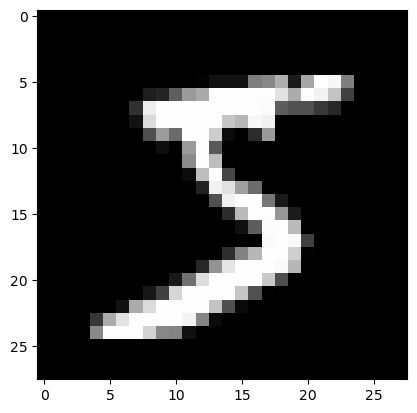

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
pyplot.show()

Preparing the dataset for PyTorch. 

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape, y_train.shape) # The size of each x is 784, which is 28**2.
print(y_train.min(), y_train.max()) # You can see the range is 0..9

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784]) torch.Size([50000])
tensor(0) tensor(9)


# Machine learning without `Module`

Here we demonstrate how to manipulate tensors. 
We manually build a MLP *without* using the given MLP layers.

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784) # Mapping the image to the label space (i.e. 0..9).
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
    # The unsqueeze invokation here makes sure that 
    # if the input is a one-dimensional tensor,
    # then so is the output tensor.
    # We expect output[i] is the log of the probability of label i. 
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

def nll(input, target):
    # PyTorch also has an interesting behavior:
    # tensor[range1, tensor2] or tensor[tensor1, range2] or ... 
    # (but not tensor[i:j, m:n]) requires the lengths of the two lists to be the same,
    # and the return value takes this form: return_value[i] = tensor[list1[i], list2[i]].
    #
    # The variable `target` is expected to give the correct answer.
    # Therefore, if `nll` is used as a loss function,
    # then minimizing the loss function means to maximize the likelihood 
    # of the correct label.
    # We don't need to minimize the likelihood of the wrong labels,
    # because this is automatically done by the softmax normalization.
    #
    # This loss function therefore is known as negative likelihood loss, or nll in short.
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Show how the model and the loss function work.

In [22]:
print(model(x_train[0].unsqueeze(0)))
print(model(x_train[0:2]))

tensor([[-2.3332, -2.0413, -2.2145, -2.5600, -2.0429, -2.4447, -2.2750, -2.7164,
         -2.3864, -2.2130]], grad_fn=<SubBackward0>)
tensor([[-2.3332, -2.0413, -2.2145, -2.5600, -2.0429, -2.4447, -2.2750, -2.7164,
         -2.3864, -2.2130],
        [-2.0381, -2.6736, -2.4797, -2.5111, -1.9558, -2.2750, -2.0931, -2.6254,
         -3.1621, -1.8742]], grad_fn=<SubBackward0>)


In [7]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)   # predictions
yb = y_train[0:bs]

nll(preds, yb)

tensor(2.3188, grad_fn=<NegBackward0>)

In [8]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))


tensor(0.0938)


In [10]:
n_epoch = 10
accuracies = np.zeros(n_epoch)

lr = 0.002

for i_epoch in range(n_epoch):
    for i_batch in range(n // bs + 1):
        i_start = i_batch * bs
        i_end = (i_batch + 1) * bs
        x_batch = x_train[i_start:i_end, :]
        y_batch = y_train[i_start:i_end]
        
        preds = model(x_batch)
        loss = nll(preds, y_batch)
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    
    with torch.no_grad():
        acc = accuracy(model(x_train), y_train).item()
        accuracies[i_epoch] = acc
        print(f"epoch: {i_epoch:>3d}   accuracy: {acc:>5f}")

epoch:   0   accuracy: 0.756780
epoch:   1   accuracy: 0.815020
epoch:   2   accuracy: 0.834100
epoch:   3   accuracy: 0.843860
epoch:   4   accuracy: 0.850960
epoch:   5   accuracy: 0.855940
epoch:   6   accuracy: 0.860260
epoch:   7   accuracy: 0.863600
epoch:   8   accuracy: 0.866320
epoch:   9   accuracy: 0.868640


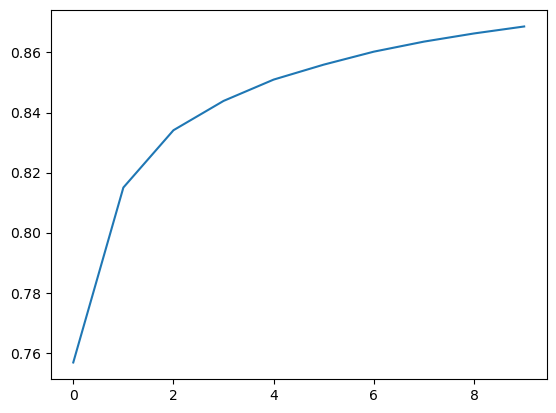

In [12]:
pyplot.plot(accuracies)

# Machine learning using `Module` but not pre-defined networks 

Note that `Module` is orthogonal to the exact architecture of the model:
we can build a non-neural network model using `Module`,
and we can also build a neural network without using `Module`. 
Similarly we also use an optimizer instead of manually manipulate the parameters in the model.

In [10]:
from torch import nn

class MnistMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, x_batch):
        return log_softmax(x_batch @ self.weight + self.bias)

In [14]:
model = MnistMLP()
n_epoch = 10
accuracies = np.zeros(n_epoch)

lr = 0.002

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for i_epoch in range(n_epoch):
    for i_batch in range(n // bs + 1):
        i_start = i_batch * bs
        i_end = (i_batch + 1) * bs
        x_batch = x_train[i_start:i_end, :]
        y_batch = y_train[i_start:i_end]
        
        preds = model(x_batch)
        loss = nll(preds, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

            
    with torch.no_grad():
        acc = accuracy(model(x_train), y_train).item()
        accuracies[i_epoch] = acc
        print(f"epoch: {i_epoch:>3d}   accuracy: {acc:>5f}")

epoch:   0   accuracy: 0.768120
epoch:   1   accuracy: 0.814380
epoch:   2   accuracy: 0.832340
epoch:   3   accuracy: 0.843140
epoch:   4   accuracy: 0.850360
epoch:   5   accuracy: 0.855720
epoch:   6   accuracy: 0.859540
epoch:   7   accuracy: 0.863080
epoch:   8   accuracy: 0.865520
epoch:   9   accuracy: 0.868280


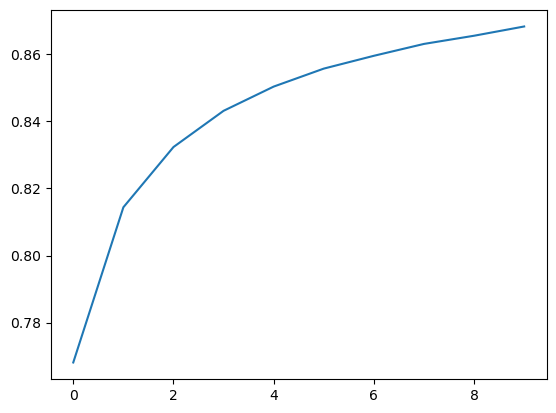

In [15]:
pyplot.plot(accuracies)

Note that if we desire, we can still manually manipulate the parameters of the model.

In [30]:
for i in model.parameters():
    print(i.shape)

torch.Size([784, 10])
torch.Size([10])


Validate the model: see the images it fails at.

In [25]:
y_valid[0]

tensor(3)

In [39]:
i_fail = []
for i in range(y_valid.shape[0]):
    n_pred = model(x_valid[i, :].unsqueeze(0)).argmax().item()
    n_real = y_valid[i].item()
    if n_pred != n_real:
        i_fail.append(i) 

print(len(i_fail))

1118


Correct answer   : 4
Wrong prediction : 9


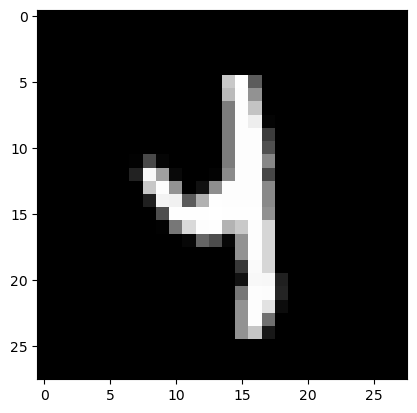

In [52]:
i_i_fail = 10 
print("Correct answer   :", y_valid[i_fail[i_i_fail]].item())
print("Wrong prediction :", model(x_valid[i_fail[i_i_fail]]).argmax().item())
pyplot.imshow(x_valid[i_fail[i_i_fail], :].reshape([28, 28]), cmap="gray")

# Machine learning using predefined neural network components

The neural network we just implemented is a standard MLP 
and PyTorch has offered us mature infrastructures,
namely `Linear` and activation functions,
to implement it.
These predefined components are `Module`s themselves

In [9]:
class MnistMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x_batch):
        return self.logsoftmax(self.lin(x_batch)) 

NameError: name 'nn' is not defined

The loss function is also predefined.

In [11]:
n_epoch = 10
lr = 0.002

model = MnistMLP()
loss_func = nn.NLLLoss()
accuracies = np.zeros(n_epoch)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for i_epoch in range(n_epoch):
    for i_batch in range(n // bs + 1):
        i_start = i_batch * bs
        i_end = (i_batch + 1) * bs
        x_batch = x_train[i_start:i_end, :]
        y_batch = y_train[i_start:i_end]
        
        preds = model(x_batch)
        loss = loss_func(preds, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

            
    with torch.no_grad():
        acc = accuracy(model(x_train), y_train).item()
        accuracies[i_epoch] = acc
        print(f"epoch: {i_epoch:>3d}   accuracy: {acc:>5f}")

epoch:   0   accuracy: 0.745920
epoch:   1   accuracy: 0.802660
epoch:   2   accuracy: 0.825560
epoch:   3   accuracy: 0.838580
epoch:   4   accuracy: 0.847240
epoch:   5   accuracy: 0.853100
epoch:   6   accuracy: 0.857840
epoch:   7   accuracy: 0.861760
epoch:   8   accuracy: 0.864860
epoch:   9   accuracy: 0.867900


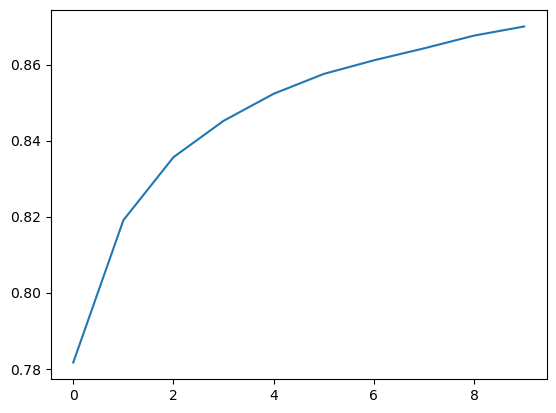

In [35]:
pyplot.plot(accuracies)

In [41]:
i_fail = []
for i in range(y_valid.shape[0]):
    n_pred = model(x_valid[i, :].unsqueeze(0)).argmax().item()
    n_real = y_valid[i].item()
    if n_pred != n_real:
        i_fail.append(i) 

print(len(i_fail))

1150


Correct answer   : 4
Wrong prediction : 9


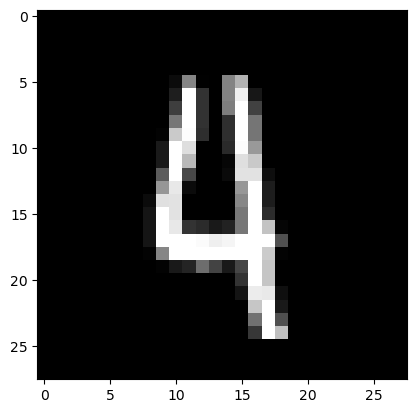

In [43]:
i_i_fail = 0 
print("Correct answer   :", y_valid[i_fail[i_i_fail]].item())
print("Wrong prediction :", 
    model(x_valid[i_fail[i_i_fail], :].unsqueeze(0)).argmax().item())
pyplot.imshow(x_valid[i_fail[i_i_fail], :].reshape([28, 28]), cmap="gray")

# Using `DataLoader` 

In [12]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = DataLoader(TensorDataset(x_train, y_train), batch_size=bs)

model = MnistMLP()
loss_func = nn.NLLLoss()
accuracies = np.zeros(n_epoch)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epoch):
    for xb, yb in train_dataset:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad()
    
    with torch.no_grad():
        acc = accuracy(model(x_train), y_train).item()
        accuracies[i_epoch] = acc
        print(f"epoch: {epoch:>3d}   accuracy: {acc:>5f}")

epoch:   0   accuracy: 0.761020
epoch:   1   accuracy: 0.807140
epoch:   2   accuracy: 0.827200
epoch:   3   accuracy: 0.838880
epoch:   4   accuracy: 0.846520
epoch:   5   accuracy: 0.851920
epoch:   6   accuracy: 0.856720
epoch:   7   accuracy: 0.860500
epoch:   8   accuracy: 0.864000
epoch:   9   accuracy: 0.867240


# Moving to CNN

In [13]:
import torch.nn.functional as F

class MnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        # xb is a batch, its first dimension corresponding to samples index in the batch.
        # Since the first convolution layer assumes there to be one channel,
        # we have to unsqueeze xb to create another dimension corresponding to the channel index.
        # Therefore the new shape becomes (number of samples, 1, 28, 28)
        xb = xb.reshape(-1, 1, 28, 28) 
        xb = F.relu(self.conv1(xb)) 
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        # Here 4 is the pooling kernel; that's to say, 
        # if the input is 10×4×4, then the output is 10×1×1.
        # Therefore after xb.view, the output dimension becomes 10,
        # or to be more precise, number of sample in input batch × 10.
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))


Here to speedup training, it's time to move the heavylifting part to GPUs. 

In [62]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = DataLoader(TensorDataset(x_train, y_train), batch_size=bs)

n_epoch = 10
lr = 0.1

loss_func = nn.NLLLoss()
accuracies = np.zeros(n_epoch)

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = MnistCNN().to(dev)
x_valid = x_valid.to(dev)
y_valid = y_valid.to(dev)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epoch):
    model.train()
    for xb, yb in train_dataset:
        xb = xb.to(dev)
        yb = yb.to(dev)

        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad()
    
    model.eval()
    with torch.no_grad():
        acc = accuracy(model(x_valid), y_valid).item()
        accuracies[i_epoch] = acc
        print(f"epoch: {epoch:>3d}   accuracy: {acc:>5f}")

epoch:   0   accuracy: 0.099100
epoch:   1   accuracy: 0.099100
epoch:   2   accuracy: 0.099100
epoch:   3   accuracy: 0.099100
epoch:   4   accuracy: 0.099100
epoch:   5   accuracy: 0.099100
epoch:   6   accuracy: 0.099100
epoch:   7   accuracy: 0.099100
epoch:   8   accuracy: 0.099100
epoch:   9   accuracy: 0.099100


In [64]:
for (i, p) in enumerate(model.parameters()):
    print(i)
    print(p)

0
Parameter containing:
tensor([[[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan

For some reasons all parameters in the model become `nan`.

In [54]:
model = MnistCNN().to(dev)
model(x_valid[0, :].unsqueeze(0).to(dev))
xb, yb = next(iter(train_dataset))
xb = xb.to(dev)
yb = yb.to(dev)
pred = model(xb)
loss = loss_func(pred, yb)
loss.backward()
optimizer.step()
optimizer.zero_grad()
model(xb)

tensor([[4.1214e-03, 4.5030e-02, 2.4851e-02, 0.0000e+00, 4.1709e-02, 1.2033e-02,
         0.0000e+00, 0.0000e+00, 6.3161e-02, 3.1962e-02],
        [1.9010e-03, 4.7667e-02, 2.4808e-02, 0.0000e+00, 4.0000e-02, 1.3844e-02,
         0.0000e+00, 1.6034e-03, 6.2248e-02, 3.1122e-02],
        [9.0393e-04, 5.3414e-02, 2.2639e-02, 0.0000e+00, 4.0941e-02, 2.1256e-02,
         0.0000e+00, 0.0000e+00, 6.1555e-02, 2.7697e-02],
        [4.5438e-04, 4.9773e-02, 2.1821e-02, 0.0000e+00, 4.0696e-02, 1.1536e-02,
         0.0000e+00, 1.8418e-03, 6.3721e-02, 3.1940e-02],
        [3.4171e-03, 3.7358e-02, 2.2080e-02, 0.0000e+00, 4.0498e-02, 1.0866e-02,
         0.0000e+00, 1.0235e-03, 6.6782e-02, 3.0062e-02],
        [5.4433e-03, 4.0132e-02, 3.1950e-02, 0.0000e+00, 3.1492e-02, 1.6327e-02,
         0.0000e+00, 0.0000e+00, 6.5445e-02, 3.0817e-02],
        [2.5435e-03, 4.5891e-02, 1.7974e-02, 0.0000e+00, 4.1023e-02, 5.5511e-03,
         0.0000e+00, 0.0000e+00, 5.9580e-02, 3.1576e-02],
        [2.7243e-03, 4.9264

In [61]:
xb, yb = next(iter(train_dataset))
xb = xb.to(dev)
yb = yb.to(dev)
pred = model(xb)
loss = loss_func(pred, yb)
loss.backward()
optimizer.step()

for (i, p) in enumerate(model.parameters()):
    print(i)
    print(p.grad)

0
tensor([[[[-2.5437e-03, -1.3409e-03, -3.2205e-04],
          [-1.8314e-03, -5.1764e-04,  6.3209e-04],
          [-5.2615e-04, -1.1466e-04,  1.4523e-05]]],


        [[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],


        [[[ 9.2044e-04,  9.6565e-04, -2.8217e-04],
          [ 8.1299e-04,  8.6477e-04, -1.4487e-04],
          [ 1.8600e-03,  1.3320e-03,  1.0087e-03]]],


        [[[-1.3418e-03, -3.0599e-04,  3.2747e-04],
          [-9.0160e-04, -1.3140e-04,  5.3013e-04],
          [-1.3985e-04,  8.1400e-05,  5.9792e-04]]],


        [[[ 1.2014e-04,  2.7647e-04,  8.4351e-04],
          [ 8.0084e-06,  1.6117e-04,  4.4153e-04],
          [-1.2365e-04, -8.7139e-05,  1.4536e-04]]],


        [[[ 6.8949e-05, -9.7680e-05, -1.4818e-04],
          [ 5.0679e-05, -6.5738e-05, -1.4660e-05],
          [ 7.0374e-06, -2.7872e-05, -1.3249e-04]]],


        [[[ 2.1787e-03,  7.5444e-04, -7.5028e-04],
     

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.